# Challenge: What Test to Use
Using selected questions from the 2012 and 2014 editions of the [European Social Survey](http://www.europeansocialsurvey.org/data/round-index.html), address the following questions. Keep track of your code and results in a Jupyter notebook or other source that you can share with your mentor. For each question, explain why you chose the approach you did.

Here is the [data file](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv). And here is the [codebook](https://thinkful-ed.github.io/data-201-resources/ESS_practice_data/ESS_codebook.html), with information about the variable coding and content.

In this dataset, the same participants answered questions in 2012 and again 2014.

1. Did people become less trusting from 2012 to 2014? Compute results for each country in the sample.
2. Did people become happier from 2012 to 2014? Compute results for each country in the sample.
3. Who reported watching more TV in 2012: men or women?
4. Who was more likely to believe people were fair in 2012: people living with a partner or people living alone?
5. Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?
6. Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

As a reminder:


<table border="1">
<tr>
<th>Experiment Type</th>
<th colspan="2">Normally Distributed</th>
<th colspan="2">Non-Normally Distributed</th>
</tr>
<tr>
<th></th>
<th>Test</th>
<th>Function</th>
<th>Test</th>
<th>Function</th>
</tr>
<tr>
<td>A/B Test<br>
of Independent Groups</td>
<td>T-Test for independent samples</td>
<td>[`scipy.stats.ttest_ind`]</td>
<td>Mann-Whitney U test<br>
Moon's Median Test<br>
Kruskal-Wallis Test</td>
<td>[`scipy.stats.mannwhitneyu`]<br>
[`scipy.stats.median_test`]<br>
[`scipy.stats.kruskal`]</td>
</tr>
<tr>
<td>A/B/C/… Test<br>
of Three or More Independent Groups</td>
<td>One-way ANOVA</td>
<td>[`scipy.stats.f_oneway`]</td>
<td>Mood’s median test<br>
Kruskal-Wallis test</td>
<td>[`scipy.stats.median_test`]<br>
[`scipy.stats.kruskal`]</td>
</tr>
<tr>
<td>A/B Test<br>
where all participants experience both versions</td>
<td>T-Test for paired samples</td>
<td>[`scipy.stats.ttest_rel`]</td>
<td>Wilcoxon signed-rank test</td>
<td>[`scipy.stats.wilcoxon`]</td>
</tr>
</table>

In [121]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [8]:
# Loading and previewing data
df = pd.read_csv('european_survey_data.csv')
print(df.shape)
df.head()

(8594, 13)


,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [9]:
# Observing types of data, unique, NaN, and sample in all features
def snapshot(data):
    '''Creates a DataFrame that gives snapshot of original dataset for preliminary cleaning and analysis.'''
    preliminary_details = pd.DataFrame()
    preliminary_details['Type'] = data.dtypes
    preliminary_details['Unique'] = data.nunique()
    preliminary_details['NaN'] = data.isnull().sum()
    preliminary_details['Sample'] = data.sample().T
    return preliminary_details
snapshot(df)

,Type,Unique,NaN,Sample
cntry,object,6,0,NO
idno,float64,3086,0,15642
year,int64,2,0,6
tvtot,float64,8,8,3
ppltrst,float64,11,14,5
pplfair,float64,11,39,10
pplhlp,float64,11,25,6
happy,float64,11,31,10
sclmeet,float64,7,15,7
sclact,float64,5,94,5


## Question 1: Did people become less trusting from 2012 to 2014?
While similar, the two groups are made up of different people (and are, therefore, independent of each other). If they are normally distributed (Gaussian), we will use ttest_ind for independent samples; if they are non-normally distributed, we will use mannwhitneyu test.

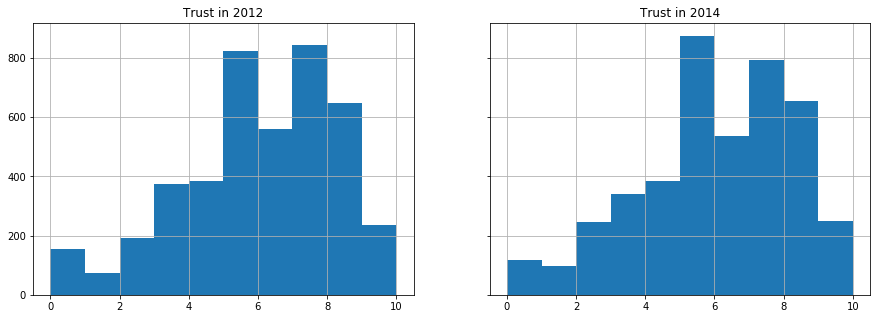

Average Trust in 2012: 5.563097737345463 			 Average Trust in 2014: 5.556720242254833


In [60]:
df_2012 = df[df.year == 6]
df_2014 = df[df.year == 7]

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

df_2012.ppltrst.hist(ax=axes[0])
df_2014.ppltrst.hist(ax=axes[1])
axes[0].set_title('Trust in 2012')
axes[1].set_title('Trust in 2014')

plt.show()
print('Average Trust in 2012: {}'.format(np.mean(df_2012.ppltrst)), 
      '\t\t\t Average Trust in 2014: {}'.format(np.mean(df_2014.ppltrst)))

While they have strong appearances of being normally distributed, let's perform the Shapiro-Wilk test statistic for fun in order to quantify just how normal these distributions are.

\begin{align} 
W=\frac { (\sum_{i=1}^n a_ix_{(i)} )^2}{ \sum_{i=1}^n (x_i-\bar{x})^2}
\end{align}

In [47]:
print(stats.shapiro(df_2012.ppltrst.dropna()))
print(stats.shapiro(df_2014.ppltrst.dropna()))

(0.9523736834526062, 3.045615175428091e-35)
(0.9583832025527954, 2.1650820660101225e-33)


Both test statistic values are very close to 1 indicating they are indeed normally distributed. Therefore, we will use the ttest_ind to assess whether or not people became less trusting. 

In [59]:
stats.ttest_ind(df_2012.ppltrst.dropna(), df_2014.ppltrst.dropna(), equal_var = False)

Ttest_indResult(statistic=0.13222494679695282, pvalue=0.8948094709117252)

**Answer**: Because the two groups were independent and normally distributed, we implemented the T-Test which showed that people did become slightly less trustworthy (noted by the average trust of years and the positive t-value), but this lacked a statistically significant p-value. Therefore, we cannot reject the null hypothesis and cannot statistically affirm that people became less trustworthy.

## Question 2: Did people become happier from 2012 to 2014?

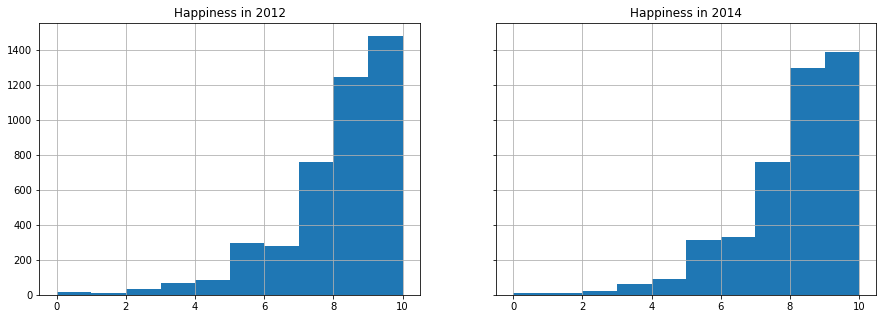

Average Happiness in 2012: 7.723573433115061 			 Average Happiness in 2014: 7.665733613249358


In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

df_2012.happy.hist(ax=axes[0])
df_2014.happy.hist(ax=axes[1])
axes[0].set_title('Happiness in 2012')
axes[1].set_title('Happiness in 2014')

plt.show()
print('Average Happiness in 2012: {}'.format(np.mean(df_2012.happy)), 
      '\t\t\t Average Happiness in 2014: {}'.format(np.mean(df_2014.happy)))

In [64]:
print(stats.shapiro(df_2012.happy.dropna()))
print(stats.shapiro(df_2014.happy.dropna()))

(0.8950968980789185, 0.0)
(0.90348219871521, 0.0)


In [66]:
stats.ttest_ind(df_2012.happy.dropna(), df_2014.happy.dropna(), equal_var = False)

Ttest_indResult(statistic=1.5416999272322065, pvalue=0.12318353845848014)

**Answer**: Because the two groups were independent and normally distributed (according to inverted chi-square/log normal distributions), we implemented the T-Test which revealed that, overall, people did not become happier (noted by the average happiness of years and the positive t-value), but - once again - this lacked a statistically significant p-value. Therefore, we cannot reject the null hypothesis and cannot statistically affirm that people became happier.

## Question 3: Who reported watching more TV in 2012: men or women?

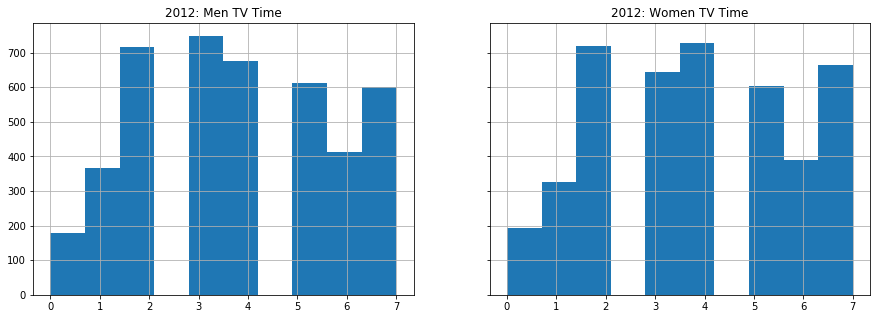

Count of Men: 4287 						 Count of Women: 4293
Average TV Time for Men: 5.563097737345463 			 Average TV Time for Women: 5.556720242254833
Sum of TV Time for Men: 23849.0 				 Sum of TV Time for Women: 23855.0


In [96]:
df_2012_men = df[df.gndr == 1]
df_2012_women = df[df.gndr == 2]

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
df_2012_men.tvtot.hist(ax=axes[0])
df_2012_women.tvtot.hist(ax=axes[1])
axes[0].set_title('2012: Men TV Time')
axes[1].set_title('2012: Women TV Time')

plt.show()
print('Count of Men: {}'.format(len(df_2012.ppltrst.dropna())), 
      '\t\t\t\t\t\t Count of Women: {}'.format(len(df_2014.ppltrst.dropna())))
print('Average TV Time for Men: {}'.format(np.mean(df_2012.ppltrst)), 
      '\t\t\t Average TV Time for Women: {}'.format(np.mean(df_2014.ppltrst)))
print('Sum of TV Time for Men: {}'.format(np.sum(df_2012.ppltrst)), 
      '\t\t\t\t Sum of TV Time for Women: {}'.format(np.sum(df_2014.ppltrst)))

In [71]:
print(stats.shapiro(df_2012_men.tvtot.dropna()))
print(stats.shapiro(df_2012_women.tvtot.dropna()))

(0.9438452124595642, 1.0865809543259836e-37)
(0.9410152435302734, 3.082838965153947e-38)


In [72]:
stats.ttest_ind(df_2012_men.tvtot.dropna(), df_2012_women.tvtot.dropna(), equal_var = False)

Ttest_indResult(statistic=-1.5366511037720088, pvalue=0.12441569444006385)

**Answer**: According to the averages, sums, and t-tests, we can affirm that women reportedly watch more TV than men. However, because the p-value was not statistically significant, we cannot infer that the same is true for the entire population. (As before, the two groups were independent and relatively normally distributed (according to normal/Gaussian distributions), so we implemented the T-Test.)

## Question 4: Who was more likely to believe people were fair in 2012: people living with a partner or people living alone?

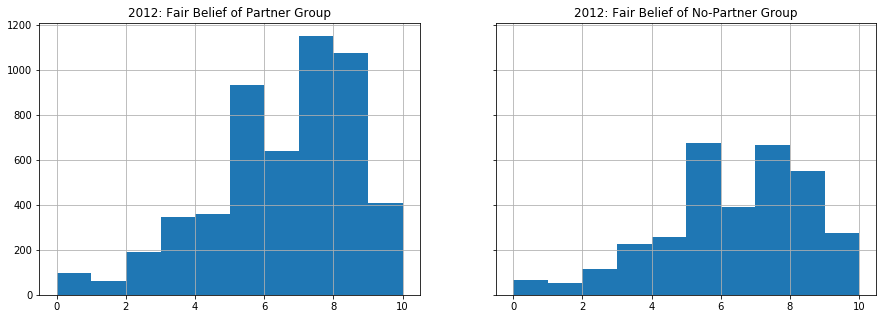

Count for Partner Group: 5259 					 Count for No-Partner Group: 3280
Fair Belief for Partner Group: 6.063890473474045 		 Fair Belief for No-Partner Group: 5.911280487804878


In [95]:
df_2012_yespartner = df[df.partner == 1]
df_2012_nopartner = df[df.partner == 2]

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
df_2012_yespartner.pplfair.hist(ax=axes[0])
df_2012_nopartner.pplfair.hist(ax=axes[1])
axes[0].set_title('2012: Fair Belief of Partner Group')
axes[1].set_title('2012: Fair Belief of No-Partner Group')

plt.show()

print('Count for Partner Group: {}'.format(len(df_2012_yespartner.pplfair.dropna())), 
      '\t\t\t\t\t Count for No-Partner Group: {}'.format(len(df_2012_nopartner.pplfair.dropna())))
print('Fair Belief for Partner Group: {}'.format(np.mean(df_2012_yespartner.pplfair)), 
      '\t\t Fair Belief for No-Partner Group: {}'.format(np.mean(df_2012_nopartner.pplfair)))

In [97]:
print(stats.shapiro(df_2012_yespartner.pplfair.dropna()))
print(stats.shapiro(df_2012_nopartner.pplfair.dropna()))

(0.9431131482124329, 5.365711949746157e-41)
(0.9564833045005798, 3.0214600224609384e-30)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [98]:
stats.ttest_ind(df_2012_yespartner.pplfair.dropna(), df_2012_nopartner.pplfair.dropna(), equal_var = False)

Ttest_indResult(statistic=3.2038704773255624, pvalue=0.0013621612869426684)

**Answer**: Finally! People living with a partner were more likely to believe others fair. The p-value below 5% confirms that this is not due to randomness.

## Question 5: Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?

In [101]:
df_2014.cntry.value_counts()

ES    1213
SE     908
CH     773
NO     731
CZ     658
DE      14
Name: cntry, dtype: int64

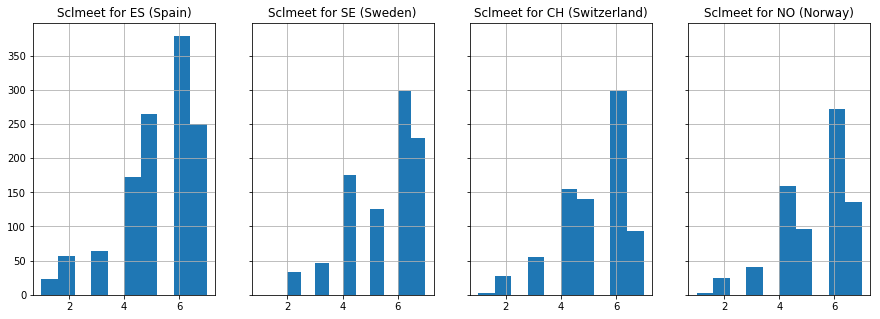

Count: 1211 			 Count: 908 			 Count: 772 		 Count: 731
Average: 5.2601156069364166 	Average: 5.426211453744493 	Average: 5.160621761658031 Average: 5.3023255813953485


In [154]:
# Selecting largest countries for greatest sample sizes
df_2014_es = df_2014[df_2014.cntry == 'ES']
df_2014_se = df_2014[df_2014.cntry == 'SE']
df_2014_ch = df_2014[df_2014.cntry == 'CH']
df_2014_no = df_2014[df_2014.cntry == 'NO']

fig, axes = plt.subplots(1, 4, figsize=(15,5), sharex=True, sharey=True)
df_2014_es.sclmeet.hist(ax=axes[0])
df_2014_se.sclmeet.hist(ax=axes[1])
df_2014_ch.sclmeet.hist(ax=axes[2])
df_2014_no.sclmeet.hist(ax=axes[3])
axes[0].set_title('Sclmeet for ES (Spain)')
axes[1].set_title('Sclmeet for SE (Sweden)')
axes[2].set_title('Sclmeet for CH (Switzerland)')
axes[3].set_title('Sclmeet for NO (Norway)')

plt.show()

print('Count: {}'.format(len(df_2014_es.sclmeet.dropna())), 
      '\t\t\t Count: {}'.format(len(df_2014_se.sclmeet.dropna())), 
      '\t\t\t Count: {}'.format(len(df_2014_ch.sclmeet.dropna())), 
      '\t\t Count: {}'.format(len(df_2014_no.sclmeet.dropna())))
print('Average: {}'.format(np.mean(df_2014_es.sclmeet)), 
      '\tAverage: {}'.format(np.mean(df_2014_se.sclmeet)), 
      '\tAverage: {}'.format(np.mean(df_2014_ch.sclmeet)), 
      'Average: {}'.format(np.mean(df_2014_no.sclmeet)))

In [133]:
sclmeet_records=np.asarray(df_2014_es.sclmeet.dropna().tolist() +
                           df_2014_se.sclmeet.dropna().tolist() +
                           df_2014_ch.sclmeet.dropna().tolist() +
                           df_2014_no.sclmeet.dropna().tolist())

sclmeet_countries = np.array(['es'] * len(df_2014_es.sclmeet.dropna()) +
                ['se'] * len(df_2014_se.sclmeet.dropna()) +
                ['ch'] * len(df_2014_ch.sclmeet.dropna()) +
                ['no'] * len(df_2014_no.sclmeet.dropna()))

tukey = pairwise_tukeyhsd(endog=sclmeet_records,      # Data
                          groups=sclmeet_countries,   # Groups
                          alpha=0.05)         # Significance level

tukey.summary()  

group1,group2,meandiff,lower,upper,reject
ch,es,0.0995,-0.0647,0.2637,False
ch,no,0.1417,-0.0423,0.3257,False
ch,se,0.2656,0.091,0.4402,True
es,no,0.0422,-0.1248,0.2092,False
es,se,0.1661,0.0096,0.3226,True
no,se,0.1239,-0.0533,0.3011,False


**Answer**: The most consistent stand-out country was Sweden with a noticeably higher score (except when compared to Norway).

## Question 6: Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

In [150]:
age_bins = pd.qcut(df_2014.agea, 4, labels=['15-33','33-47','47-62','62-114'])
age_bins.value_counts()

15-33     1096
47-62     1087
33-47     1023
62-114     978
Name: agea, dtype: int64

In [151]:
df_2014['age_bins'] = age_bins
df_2014.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,age_bins
773,CH,5.0,7,2.0,8.0,9.0,7.0,9.0,6.0,4.0,1.0,69.0,1.0,62-114
774,CH,25.0,7,4.0,4.0,2.0,5.0,6.0,5.0,3.0,1.0,30.0,1.0,15-33
775,CH,26.0,7,3.0,8.0,8.0,6.0,8.0,7.0,5.0,2.0,49.0,2.0,47-62
776,CH,28.0,7,2.0,7.0,7.0,5.0,9.0,6.0,2.0,1.0,51.0,1.0,47-62
777,CH,29.0,7,2.0,4.0,7.0,0.0,8.0,6.0,2.0,2.0,32.0,2.0,15-33


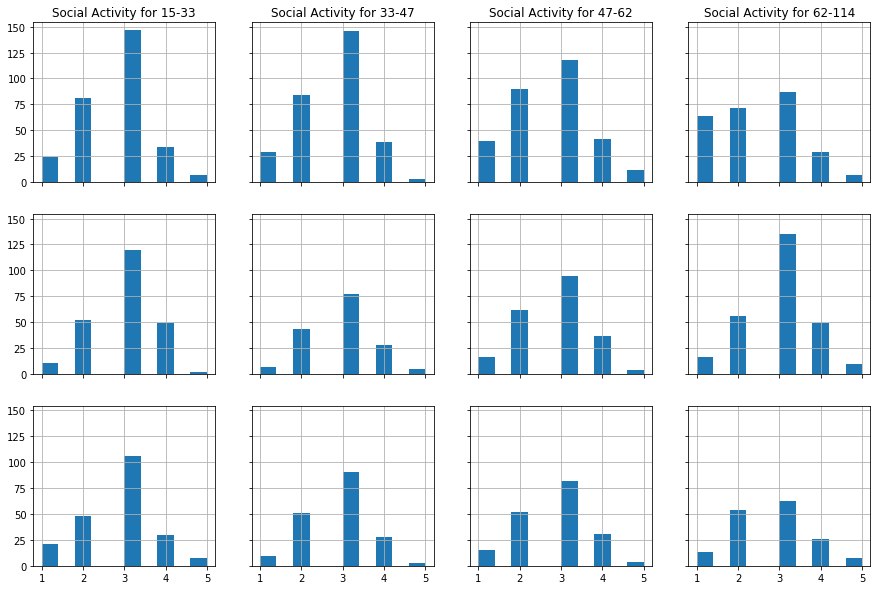

In [166]:
# Selecting largest countries for greatest sample sizes
df_2014_es = df_2014[df_2014.cntry == 'ES']
df_2014_se = df_2014[df_2014.cntry == 'SE']
df_2014_ch = df_2014[df_2014.cntry == 'CH']

fig, axes = plt.subplots(3, 4, figsize=(15,10), sharex=True, sharey=True)

df_2014_es.sclact[df_2014_es.age_bins == '15-33'].hist(ax=axes[0,0])
df_2014_es.sclact[df_2014_es.age_bins == '33-47'].hist(ax=axes[0,1])
df_2014_es.sclact[df_2014_es.age_bins == '47-62'].hist(ax=axes[0,2])
df_2014_es.sclact[df_2014_es.age_bins == '62-114'].hist(ax=axes[0,3])

df_2014_se.sclact[df_2014_se.age_bins == '15-33'].hist(ax=axes[1,0])
df_2014_se.sclact[df_2014_se.age_bins == '33-47'].hist(ax=axes[1,1])
df_2014_se.sclact[df_2014_se.age_bins == '47-62'].hist(ax=axes[1,2])
df_2014_se.sclact[df_2014_se.age_bins == '62-114'].hist(ax=axes[1,3])

df_2014_ch.sclact[df_2014_ch.age_bins == '15-33'].hist(ax=axes[2,0])
df_2014_ch.sclact[df_2014_ch.age_bins == '33-47'].hist(ax=axes[2,1])
df_2014_ch.sclact[df_2014_ch.age_bins == '47-62'].hist(ax=axes[2,2])
df_2014_ch.sclact[df_2014_ch.age_bins == '62-114'].hist(ax=axes[2,3])

axes[0,0].set_title('Social Activity for 15-33')
axes[0,1].set_title('Social Activity for 33-47')
axes[0,2].set_title('Social Activity for 47-62')
axes[0,3].set_title('Social Activity for 62-114')

plt.show()

In [168]:
es_sclact_numbers=np.asarray(df_2014_es.sclact[df_2014_es.age_bins == '15-33'].dropna().tolist() +
                           df_2014_es.sclact[df_2014_es.age_bins == '33-47'].dropna().tolist() +
                           df_2014_es.sclact[df_2014_es.age_bins == '47-62'].dropna().tolist() +
                           df_2014_es.sclact[df_2014_es.age_bins == '62-114'].dropna().tolist())

es_sclact_groups = np.array(['15-33'] * len(df_2014_es.sclact[df_2014_es.age_bins == '15-33'].dropna()) +
                            ['33-47'] * len(df_2014_es.sclact[df_2014_es.age_bins == '33-47'].dropna()) +
                            ['47-62'] * len(df_2014_es.sclact[df_2014_es.age_bins == '47-62'].dropna()) +
                            ['62-114'] * len(df_2014_es.sclact[df_2014_es.age_bins == '62-114'].dropna()))

tukey = pairwise_tukeyhsd(endog=es_sclact_numbers,      # Data
                          groups=es_sclact_groups,   # Groups
                          alpha=0.05)         # Significance level

tukey.summary()  

group1,group2,meandiff,lower,upper,reject
15-33,33-47,-0.0458,-0.2456,0.154,False
15-33,47-62,-0.0679,-0.2675,0.1317,False
15-33,62-114,-0.3297,-0.5373,-0.1221,True
33-47,47-62,-0.0221,-0.2204,0.1761,False
33-47,62-114,-0.2839,-0.4902,-0.0776,True
47-62,62-114,-0.2618,-0.468,-0.0557,True


In [171]:
se_sclact_numbers=np.asarray(df_2014_se.sclact[df_2014_se.age_bins == '15-33'].dropna().tolist() +
                           df_2014_se.sclact[df_2014_se.age_bins == '33-47'].dropna().tolist() +
                           df_2014_se.sclact[df_2014_se.age_bins == '47-62'].dropna().tolist() +
                           df_2014_se.sclact[df_2014_se.age_bins == '62-114'].dropna().tolist())

se_sclact_groups = np.array(['15-33'] * len(df_2014_se.sclact[df_2014_se.age_bins == '15-33'].dropna()) +
                            ['33-47'] * len(df_2014_se.sclact[df_2014_se.age_bins == '33-47'].dropna()) +
                            ['47-62'] * len(df_2014_se.sclact[df_2014_se.age_bins == '47-62'].dropna()) +
                            ['62-114'] * len(df_2014_se.sclact[df_2014_se.age_bins == '62-114'].dropna()))

tukey = pairwise_tukeyhsd(endog=se_sclact_numbers,      # Data
                          groups=se_sclact_groups,   # Groups
                          alpha=0.05)         # Significance level

tukey.summary()  

group1,group2,meandiff,lower,upper,reject
15-33,33-47,-0.029,-0.2561,0.1981,False
15-33,47-62,-0.1392,-0.3486,0.0701,False
15-33,62-114,0.0183,-0.1801,0.2167,False
33-47,47-62,-0.1102,-0.3415,0.1211,False
33-47,62-114,0.0473,-0.1741,0.2688,False
47-62,62-114,0.1575,-0.0457,0.3608,False


In [172]:
es_sclact_numbers=np.asarray(df_2014_ch.sclact[df_2014_ch.age_bins == '15-33'].dropna().tolist() +
                           df_2014_ch.sclact[df_2014_ch.age_bins == '33-47'].dropna().tolist() +
                           df_2014_ch.sclact[df_2014_ch.age_bins == '47-62'].dropna().tolist() +
                           df_2014_ch.sclact[df_2014_ch.age_bins == '62-114'].dropna().tolist())

es_sclact_groups = np.array(['15-33'] * len(df_2014_ch.sclact[df_2014_ch.age_bins == '15-33'].dropna()) +
                            ['33-47'] * len(df_2014_ch.sclact[df_2014_ch.age_bins == '33-47'].dropna()) +
                            ['47-62'] * len(df_2014_ch.sclact[df_2014_ch.age_bins == '47-62'].dropna()) +
                            ['62-114'] * len(df_2014_ch.sclact[df_2014_ch.age_bins == '62-114'].dropna()))

tukey = pairwise_tukeyhsd(endog=es_sclact_numbers,      # Data
                          groups=es_sclact_groups,   # Groups
                          alpha=0.05)         # Significance level

tukey.summary()  

group1,group2,meandiff,lower,upper,reject
15-33,33-47,0.0143,-0.2218,0.2503,False
15-33,47-62,-0.0271,-0.2624,0.2082,False
15-33,62-114,-0.0251,-0.268,0.2178,False
33-47,47-62,-0.0414,-0.2858,0.203,False
33-47,62-114,-0.0394,-0.2911,0.2123,False
47-62,62-114,0.002,-0.2491,0.2531,False


**Answer**: Surprisingly, the only statistically significant difference between the social activity of the age groups within the different countries was in Spain where the oldest age group reportedly participated in fewer social activities.